__собираем статистики по объявлениям о продаже земли__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Вт 16 июл 2024 13:56:04 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# df = pd.read_pickle('data/2024/df_land.pkl')
# df['dt'] = df['ts'].dt.date
# display( len(df) )
# cols = ['title','address','latitude','longitude','priceM','dt']
# display( df.sample(3)[cols] )

---

In [4]:
cols = ['title','address','latitude','longitude','priceM','dt']

df = pd.read_pickle('data/2023/data_land.pkl').rename(columns={'adr':'address'})
df['dt'] = df['ts'].dt.date
display( len(df) )
display( df.sample(3)[cols] )

18854

,title,address,latitude,longitude,priceM,dt
950,"Участок 4,7 сот. (ИЖС)","Севастополь,Лагерная ул., 10В",44.59343,33.525683,4.00,2022-09-08
2575,Участок 9 сот. (ИЖС),"Севастополь,Фортификационная ул., 134к14",44.501073,33.620231,2.50,2022-09-13
17727,Участок 10 сот. (ИЖС),"Севастополь,Монастырское ш., 99/3",44.5115,33.503405,10.30,2024-06-04


In [5]:
# df_ = (
#         df_
#         .dropna(subset=['dt','url'])
#         .drop_duplicates(['dt','url'])
#         .drop(columns=['adr_orig','obj_name','avito_page'])
#     )
# display( len(df_) )
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# display( df_.sample(3)[cols] )

In [6]:
# # history_date = df_['dt'].max()
# history_date = pd.to_datetime('2023-01-10').date()
# display(history_date)

In [7]:
# df = pd.concat([df,df_]).reset_index(drop=True)
# display( len(df) )
# del df_

In [8]:
# df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
# df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

---

In [9]:
import numpy as np

df['log_priceM'] = df['priceM'].apply(lambda x: np.log(x+1.))

In [11]:
df['log_priceMU'] = df['priceMU'].apply(np.log)

---

In [12]:
df['month'] = df['ts'].dt.to_period('M')
df['week'] = df['ts'].dt.to_period('W')

---

In [13]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

18854

18854

In [14]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [15]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

,title,address,latitude,longitude,priceM,dt
6518,Участок 6 сот. (ИЖС),"Севастополь,Инкерман, садоводческое товарищество Коррида, 25",44.645726,33.613278,3.30,2022-09-19
12652,Участок 10 сот. (ИЖС),"Севастополь,Пластунский пр., 78",44.585091,33.552229,3.55,2022-11-04
18704,Участок 5 сот. (ИЖС),"Севастополь,с. Орловка, Качинское ш., 39к34",44.745336,33.543829,3.45,2024-06-05


In [16]:
display( len(df) )
gdf = gdf.query('place in ("bahchisaray","sudak","sevastopol")')
display( len(df) )

18854

18854

---

In [17]:
gdf = gdf[ gdf['dt'] < pd.to_datetime('2024-01-01').date() ]

In [18]:
dt_max = gdf['dt'].max()
dt_min = gdf['dt'].min()
display( dt_min,dt_max )
# display( dt_min,history_date,dt_max )

datetime.date(2022, 9, 8)

datetime.date(2023, 1, 10)

In [19]:
# display( len(gdf_history) )
display( len(gdf) )

17026

# общая статистика

In [21]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [22]:
# gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [23]:
# ( 
#     gdf.query('place=="sudak"')
#     [['title','address','priceM','area_size_category','geometry']]
#     #.explore('area_size_category', legend=True) 
#     .explore()    
# )

In [24]:
# (
#     gdf.query('place=="bahchisaray"')
#     [['title','address','priceM','area_size_category','geometry']]
#     #.sample(100)
#     .explore() #'area_size_category', legend=True) 
# )

In [25]:
# cols = ['title','adr','priceM','house_size_category','place','url','geometry']

In [26]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = gdf.groupby(['place','area_size_category','week'],observed=True)['priceM'].describe(percentiles=percentiles)
# stat = gdf.groupby(['place','area_size_category','month'],observed=True)['priceM'].describe(percentiles=percentiles)
display( stat )

count  mean    std  min  \
place      area_size_category week                                             
sevastopol <1                 2022-09-05/2022-09-11   4.00  4.19   7.22 0.30   
                              2022-09-12/2022-09-18  15.00  4.45   6.59 0.30   
                              2022-09-19/2022-09-25   8.00  4.19   6.68 0.30   
                              2022-09-26/2022-10-02   4.00  4.19   7.22 0.30   
                              2022-10-03/2022-10-09   3.00  0.59   0.49 0.30   
...                                                    ...   ...    ...  ...   
           20+                2022-10-31/2022-11-06  72.00 53.73 145.17 1.50   
                              2022-11-07/2022-11-13  37.00 55.33 143.90 1.50   
                              2022-11-14/2022-11-20  39.00 29.43  25.44 1.00   
                              2022-11-28/2022-12-04  34.00 54.00 149.83 3.00   
                              2023-01-09/2023-01-15  24.00 76.85 179.58 1.55   

                                                      1%   5%  10%   25%  \
place      area_size_category week                                         
sevastopol <1                 2022-09-05/2022-09-11 0.30 0.30 0.30  0.31   
                              2022-09-12/2022-09-18 0.30 0.30 0.30  0.32   
                              2022-09-19/2022-09-25 0.30 0.30 0.30  0.31   
                              2022-09-26/2022-10-02 0.30 0.30 0.30  0.31   
                              2022-10-03/2022-10-09 0.30 0.30 0.30  0.31   
...                                                  ...  ...  ...   ...   
           20+                2022-10-31/2022-11-06 1.50 1.53 2.55  7.70   
                              2022-11-07/2022-11-13 1.52 2.31 4.20 10.00   
                              2022-11-14/2022-11-20 1.21 2.86 5.20  9.99   
                              2022-11-28/2022-12-04 3.66 5.33 6.59  9.98   
                              2023-01-09/2023-01-15 1.88 3.23 6.15 14.75   

                                                      50%   75%    90%    95%  \
place      area_size_category week                                              
sevastopol <1                 2022-09-05/2022-09-11  0.73  4.61  10.84  12.92   
                              2022-09-12/2022-09-18  1.15  8.07  15.00  15.00   
                              2022-09-19/2022-09-25  0.73  4.61  15.00  15.00   
                              2022-09-26/2022-10-02  0.73  4.61  10.84  12.92   
                              2022-10-03/2022-10-09  0.32  0.73   0.98   1.07   
...                                                   ...   ...    ...    ...   
           20+                2022-10-31/2022-11-06 18.00 42.50  71.00 105.75   
                              2022-11-07/2022-11-13 21.00 50.00  73.40  97.00   
                              2022-11-14/2022-11-20 21.00 38.95  68.40  71.60   
                              2022-11-28/2022-12-04 21.00 39.42  67.00  92.05   
                              2023-01-09/2023-01-15 26.00 62.50 107.10 205.00   

                                                       max  
place      area_size_category week                          
sevastopol <1                 2022-09-05/2022-09-11  15.00  
                              2022-09-12/2022-09-18  15.00  
                              2022-09-19/2022-09-25  15.00  
                              2022-09-26/2022-10-02  15.00  
                              2022-10-03/2022-10-09   1.15  
...                                                    ...  
           20+                2022-10-31/2022-11-06 890.00  
                              2022-11-07/2022-11-13 890.00  
                              2022-11-14/2022-11-20 115.00  
                              2022-11-28/2022-12-04 890.00  
                              2023-01-09/2023-01-15 890.00  

[66 rows x 13 columns]

In [27]:
stat.reset_index()['area_size_category'].unique()

['<1', '1-2', '2-4', '4-8', '8-20', '20+']
Categories (6, object): ['<1' < '1-2' < '2-4' < '4-8' < '8-20' < '20+']

In [28]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%','75%']
sizes = [ '2-4', '4-8', '8-20']
display( sizes )

['2-4', '4-8', '8-20']

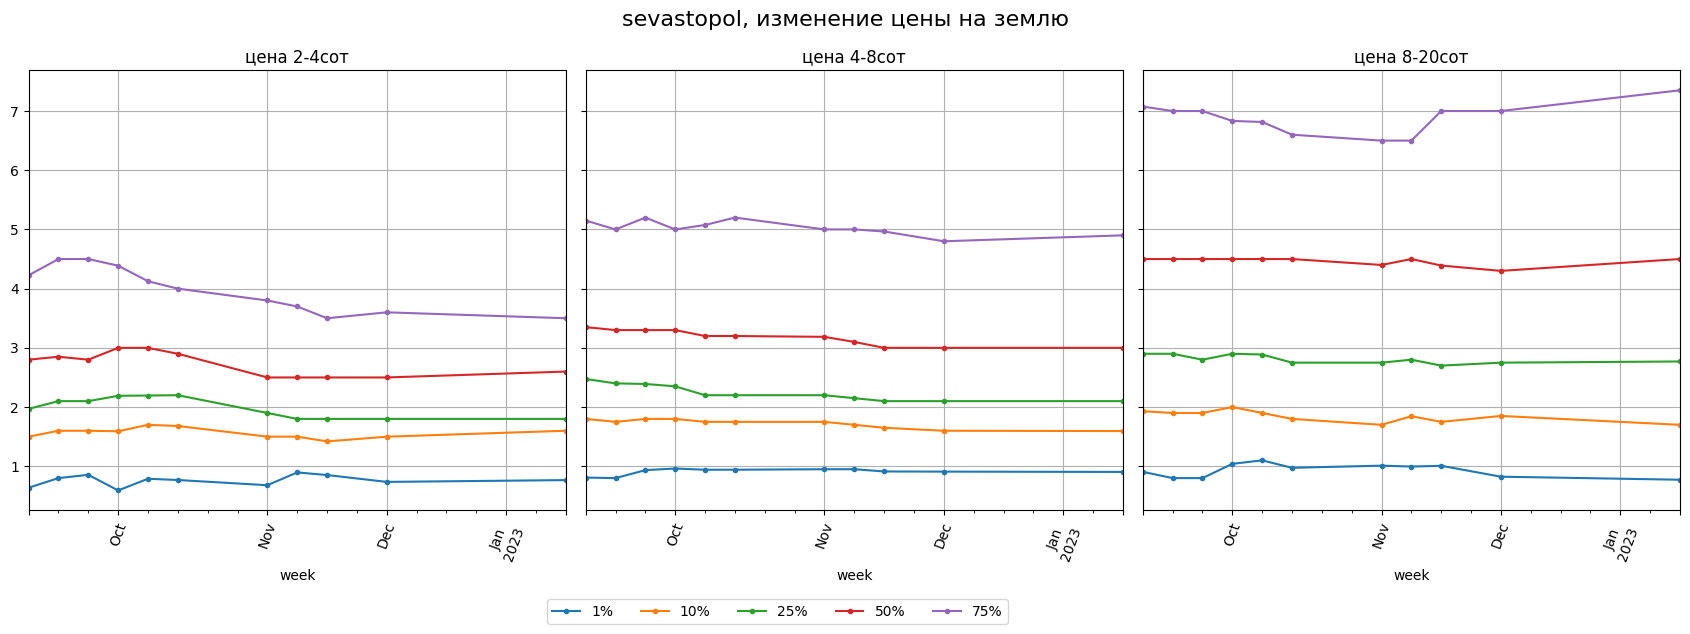

In [29]:
place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()